In [146]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, levy_stable
from tqdm import tqdm
import os
from scipy.fft import fft
from scipy.integrate import quad
from scipy.optimize import minimize

In [2]:
bitcoin = pd.read_csv('Bitcoin.csv', index_col=0)
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'].values)
#bitcoin.drop(['Symbol', 'Name', 'High', 'Low', 'Open', 'Volume', 'Marketcap'], axis=1, inplace=True)

litecoin = pd.read_csv('Litecoin.csv', index_col=0)
litecoin['Date'] = pd.to_datetime(litecoin['Date'].values)
#litecoin.drop(['Symbol', 'Name', 'High', 'Low', 'Open', 'Volume', 'Marketcap'], axis=1, inplace=True)

ripple = pd.read_csv('XRP.csv', index_col=0)
ripple['Date'] = pd.to_datetime(ripple['Date'].values)
#ripple.drop(['Symbol', 'Name', 'High', 'Low', 'Open', 'Volume', 'Marketcap'], axis=1, inplace=True)

In [3]:
bitcoin = bitcoin[bitcoin['Date'] <= pd.to_datetime('2018-02-28 23:59:59')]
litecoin = litecoin[litecoin['Date'] <= pd.to_datetime('2018-02-28 23:59:59')]
ripple = ripple[ripple['Date'] <= pd.to_datetime('2018-02-28 23:59:59')]

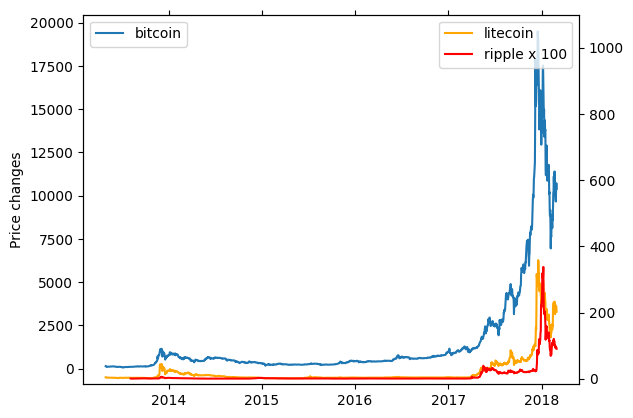

In [4]:
ax = plt.gca()
ax2 = ax.twinx()

ax.xaxis.set_tick_params(reset=True)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(bitcoin['Date'], bitcoin['Close'],label='bitcoin')
ax.legend()
ax.set_ylabel('Price changes')
ax2.plot(litecoin['Date'], litecoin['Close'], label='litecoin', color='orange')
ax2.set_ylim(ymax=1100)
ax2.plot(ripple['Date'], 100*ripple['Close'], label='ripple x 100', color='red')
ax2.legend()
plt.show()

In [5]:
bitcoin_log_returns = np.log(bitcoin['Close'].values[1:] / bitcoin['Close'].values[:-1])
litecoin_log_returns = np.log(litecoin['Close'].values[1:] / litecoin['Close'].values[:-1])
ripple_log_returns = np.log(ripple['Close'].values[1:] / ripple['Close'].values[:-1])

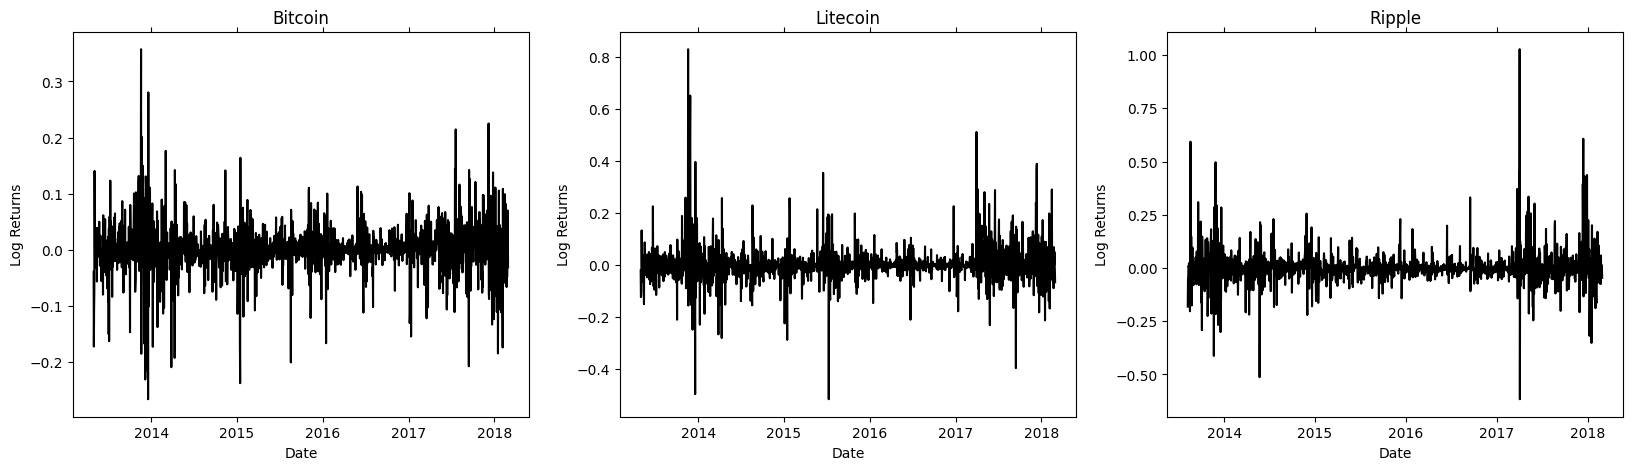

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].xaxis.set_tick_params(reset=True)
axes[0].xaxis.set_major_locator(mdates.YearLocator(1))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[0].plot(bitcoin['Date'].values[1:], bitcoin_log_returns, color='black')
axes[0].set_title('Bitcoin')
axes[0].set_ylabel('Log Returns')
axes[0].set_xlabel('Date')

axes[1].xaxis.set_tick_params(reset=True)
axes[1].xaxis.set_major_locator(mdates.YearLocator(1))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].plot(litecoin['Date'].values[1:], litecoin_log_returns, color='black')
axes[1].set_title('Litecoin')
axes[1].set_ylabel('Log Returns')
axes[1].set_xlabel('Date')

axes[2].xaxis.set_tick_params(reset=True)
axes[2].xaxis.set_major_locator(mdates.YearLocator(1))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[2].plot(ripple['Date'].values[1:], ripple_log_returns, color='black')
axes[2].set_title('Ripple')
axes[2].set_ylabel('Log Returns')
axes[2].set_xlabel('Date')

plt.show()

In [7]:
bitcoin_returns_sorted = np.sort(bitcoin_log_returns)
litecoin_returns_sorted = np.sort(litecoin_log_returns)
ripple_returns_sorted = np.sort(ripple_log_returns)

In [8]:
q_sizes = np.linspace(0.8, 1, 100, endpoint=True)
bitcoin_proportions = []

for i in q_sizes:
    low = int(len(bitcoin_returns_sorted) * (1 - i))
    high = int(len(bitcoin_returns_sorted) * i) - 1
    bitcoin_proportions.append(abs(bitcoin_returns_sorted[high] / bitcoin_returns_sorted[low]))

litecoin_proportions = []

for i in q_sizes:
    low = int(len(litecoin_returns_sorted) * (1 - i))
    high = int(len(litecoin_returns_sorted) * i) - 1
    litecoin_proportions.append(abs(litecoin_returns_sorted[high] / litecoin_returns_sorted[low]))

ripple_proportions = []

for i in q_sizes:
    low = int(len(ripple_returns_sorted) * (1 - i))
    high = int(len(ripple_returns_sorted) * i) - 1
    ripple_proportions.append(abs(ripple_returns_sorted[high] / ripple_returns_sorted[low]))

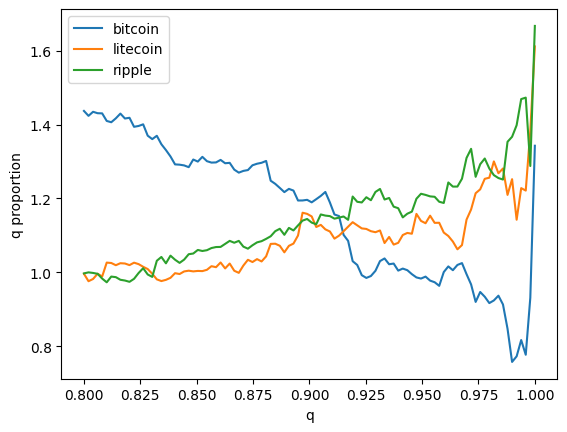

In [9]:
plt.plot(q_sizes, bitcoin_proportions, label='bitcoin')
plt.plot(q_sizes, litecoin_proportions, label='litecoin')
plt.plot(q_sizes, ripple_proportions, label='ripple')
plt.legend()
plt.ylabel('q proportion')
plt.xlabel('q')

plt.show()

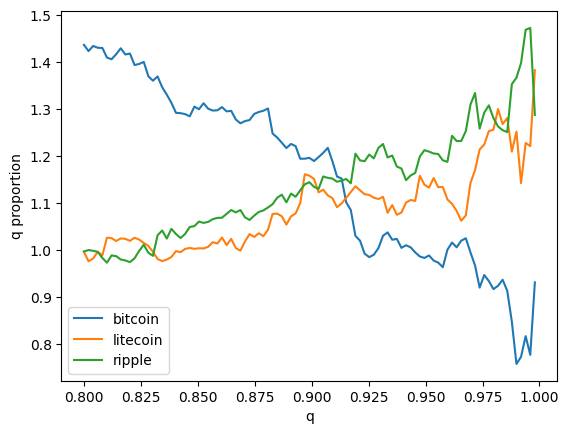

In [10]:
plt.plot(q_sizes[:-1], bitcoin_proportions[:-1], label='bitcoin')
plt.plot(q_sizes[:-1], litecoin_proportions[:-1], label='litecoin')
plt.plot(q_sizes[:-1], ripple_proportions[:-1], label='ripple')
plt.legend()
plt.ylabel('q proportion')
plt.xlabel('q')

plt.show()

In [11]:
chunk_size = 1000
shift = 85

start = len(bitcoin_log_returns)
bitcoin_chunks = []
for i in range(10):
    bitcoin_chunks.append(bitcoin_log_returns[start - shift * i - chunk_size : start - shift * i])
bitcoin_chunks = np.array(bitcoin_chunks)[::-1]

start = len(litecoin_log_returns)
litecoin_chunks = []
for i in range(10):
    litecoin_chunks.append(litecoin_log_returns[start - shift * i - chunk_size : start - shift * i])
litecoin_chunks = np.array(litecoin_chunks)[::-1]

start = len(ripple_log_returns)
ripple_chunks = []
for i in range(8):
    ripple_chunks.append(ripple_log_returns[start - shift * i - chunk_size  : start - shift * i])
ripple_chunks = np.array(ripple_chunks)[::-1]

### 1 dimension

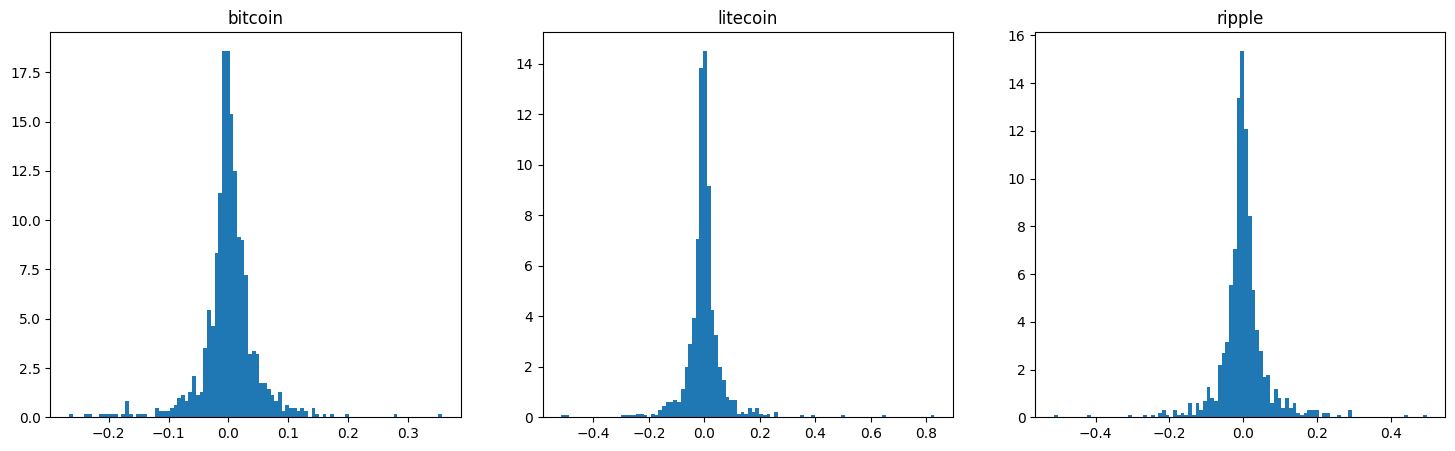

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(bitcoin_chunks[0], bins=100, density=True)
axes[0].set_title('bitcoin')
axes[1].hist(litecoin_chunks[0], bins=100, density=True)
axes[1].set_title('litecoin')
axes[2].hist(ripple_chunks[0], bins=100, density=True)
axes[2].set_title('ripple')

plt.show()

# MY ATTEMPTS (VERY BAD)

In [82]:
def integrand(t, a, x):
    return np.cos(x * t) * np.exp(-t**a)

def integral_value(a, x):
    return quad(integrand, 0, np.inf, args=(a, x))[0]

vec_integral_value = np.vectorize(integral_value)

def get_log_likelihood(a, x):
    return -np.sum(np.log(vec_integral_value(a, x)))


bnds = ((1, 2), )
for chunk in bitcoin_chunks[:1]:
    res = minimize(get_log_likelihood, 1.2, args=chunk, method='SLSQP', bounds=bnds)

In [132]:
def get_ch_fn(params, x):
    if np.isclose(params[0], 1):
        phi = -2/np.pi * np.log(np.abs(params[2]*x))
    else:
        phi = np.tan(np.pi*params[0]/2) * (np.abs(params[2]*x)**(1-params[0])-1)

    return np.exp(1j*x*params[3] - (np.abs(params[2]*x)**params[0])*(1-1j*params[1]*np.sign(x)*phi))

def get_new_like(params, x):
    return -np.sum(np.log(np.imag(fft(get_ch_fn(params, x)))))

In [133]:
bnds = ((0.4, 2), (-0.1, 0.1), (0.1, 0.2), (-0.1, 0.1))
for chunk in bitcoin_chunks[:1]:
    res = minimize(get_new_like, [1.2, 0, 0.15, 0], args=chunk, method='SLSQP', bounds=bnds)

/tmp/ipykernel_107604/4197607427.py:5: RuntimeWarning: divide by zero encountered in power
  phi = np.tan(np.pi*params[0]/2) * (np.abs(params[2]*x)**(1-params[0])-1)
/tmp/ipykernel_107604/4197607427.py:7: RuntimeWarning: invalid value encountered in multiply
  return np.exp(1j*x*params[3] - (np.abs(params[2]*x)**params[0])*(1-1j*params[1]*np.sign(x)*phi))


In [134]:
res

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: nan
       x: [ 1.200e+00  0.000e+00  1.500e-01  0.000e+00]
     nit: 1
     jac: [       nan        nan        nan        nan]
    nfev: 5
    njev: 1

# MY ATTEMPTS END(((

In [ ]:
for i in range(10):
    with open(f'bitcoin{i}.txt', 'w') as f:
        f.write('\n'.join((bitcoin_chunks[i]).astype(str)))
        f.write('\n')

for i in range(10):
    with open(f'litecoin{i}.txt', 'w') as f:
        f.write('\n'.join((litecoin_chunks[i]).astype(str)))
        f.write('\n')

In [155]:
bitcoin_estimated_params = []

for i in range(10):
    with open('commands.txt', 'w') as f:
        commands = '\n'.join(['7', f'bitcoin{i}.txt', '1', 'Y', 'N'])
        f.write(commands)
        f.write('\n')
    
    os.system('cat commands.txt | ./stablec.exe')

    with open('stable.out', 'r') as f:
        tmp = f.read()

    estimated_params = np.fromiter(map(float, tmp.strip().split('\n')[-2].split()[2:]), dtype=float)
    bitcoin_estimated_params.append(estimated_params)

bitcoin_estimated_params = np.array(bitcoin_estimated_params)[::-1]

litecoin_estimated_params = []

for i in range(10):
    with open('commands.txt', 'w') as f:
        commands = '\n'.join(['7', f'litecoin{i}.txt', '1', 'Y', 'N'])
        f.write(commands)
        f.write('\n')
    
    os.system('cat commands.txt | ./stablec.exe')

    with open('stable.out', 'r') as f:
        tmp = f.read()

    estimated_params = np.fromiter(map(float, tmp.strip().split('\n')[-2].split()[2:]), dtype=float)
    litecoin_estimated_params.append(estimated_params)

litecoin_estimated_params = np.array(litecoin_estimated_params)[::-1]



  STABLE  3.14.02 (2005/02/28)   Serial number        131
  Copyright 1997-2003 John P. Nolan (jpnolan@american.edu)

  Output file: stable.out                      

 
 Select
   1 for pdf calculations
   2 for cdf calculations
   3 for quantile calculations
   4 for generating stable random variates
   5 for setting internal tolerances for calculations
   6 for comparison of pdf and quick pdf calculations
   7 for fitting a sample with stable parameters
   8 for computing -f'/f
   9 for computing the hazard function f(x)/(1-F(x))
 Enter choice:   Input file?   Sorting data...
  Summary statistics for sample
  N=      1000            # zeros=         1
  Minimum=        -0.20753      Maximum=         0.22512    
  Quartiles=        -0.86043E-02         0.30513E-02         0.18619E-01
  Mean=         0.38363E-02   Std. dev=         0.40132E-01
  Coef. of skewness=   -0.27042      Coef. of kurtosis=     8.5178    


 1. Maximum likelihood estimators of parameters
 2. Quantile based es

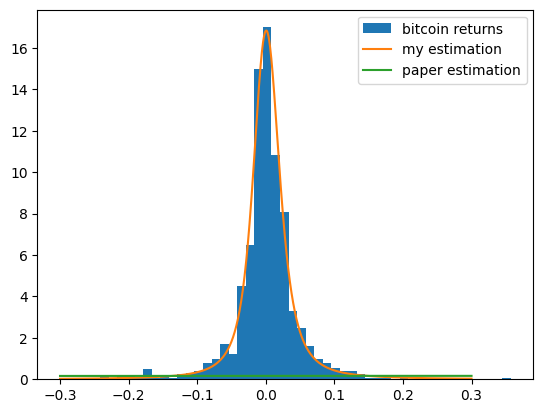

In [158]:
est_params = bitcoin_estimated_params[0]

x = np.linspace(-0.3, 0.3, 1000)
plt.hist(bitcoin_chunks[0], bins=50, density=True, label='bitcoin returns')
plt.plot(x, levy_stable.pdf(x, est_params[0], est_params[1], est_params[3], est_params[2]), label='my estimation')
plt.plot(x, levy_stable.pdf(x, 1.319, -0.014, 0.064, 1.768), label='paper estimation')

plt.legend()
plt.show()

In [159]:
bitcoin_statistics = []

for i, samples in enumerate(tqdm(bitcoin_chunks)):
    sorted_samples = np.sort(samples)

    S = 0
    for j, v in enumerate(sorted_samples):
        S += (2*j - 1)  * np.log(levy_stable.cdf(v, bitcoin_estimated_params[i][0], bitcoin_estimated_params[i][1], 
                        bitcoin_estimated_params[i][3], bitcoin_estimated_params[i][2]) * (1 - levy_stable.cdf(sorted_samples[len(sorted_samples) - 1 - j], bitcoin_estimated_params[i][0], bitcoin_estimated_params[i][1], 
                        bitcoin_estimated_params[i][3], bitcoin_estimated_params[i][2])))
    
    S /= len(sorted_samples)

    A_2 = -len(sorted_samples) - S
    bitcoin_statistics.append(A_2)

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


In [160]:
print(bitcoin_statistics)

[-3.0697081926462033, -3.190284108969081, -3.166304625262569, -2.9698615920449356, -2.9644344694469282, -2.7656688487188603, -2.5701714868720273, -2.4248894326614163, -2.424017509436112, -2.169995135869158]


In [161]:
litecoin_statistics = []

for i, samples in enumerate(tqdm(litecoin_chunks)):
    sorted_samples = np.sort(samples)

    S = 0
    for j, v in enumerate(sorted_samples):
        S += (2*j - 1)  * (np.log(levy_stable.cdf(v, litecoin_estimated_params[i][0], litecoin_estimated_params[i][1], 
                        litecoin_estimated_params[i][3], litecoin_estimated_params[i][2])) + \
        np.log(1 - levy_stable.cdf(sorted_samples[len(sorted_samples) - 1 - j], litecoin_estimated_params[i][0], litecoin_estimated_params[i][1], 
                        litecoin_estimated_params[i][3], litecoin_estimated_params[i][2])))
    
    S /= len(sorted_samples)

    A_2 = -len(sorted_samples) - S
    litecoin_statistics.append(A_2)

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


In [162]:
print(litecoin_statistics)

[-3.385926851245813, -3.351402029926021, -3.269555703674655, -3.2055428106626778, -3.391573377453142, -3.395918572424307, -3.28854273492675, -2.940439661027085, -2.7863735671726317, -2.236827130339634]


### Bivariate

In [163]:
bivariate_data = np.stack([bitcoin_chunks, litecoin_chunks], axis=1)
bivariate_deltas = np.stack([bitcoin_estimated_params[:, -1], litecoin_estimated_params[:, -1]], axis=1)

In [164]:
n = 2**3
s = np.array([[np.cos(2*np.pi*j / n), np.sin(2*np.pi*j / n)] for j in range(n)])
t = s

In [165]:
projections = t @ bivariate_data

In [168]:
with open('commands.txt', 'w') as f:
            commands = '\n'.join(['7', 'projection.txt', '1', 'Y', 'N'])
            f.write(commands)
            f.write('\n')

bivariate_params = []
for epoch in range(projections.shape[0]):
    epoch_params = []
    for projection in projections[epoch]:
        with open(f'projection.txt', 'w') as f:
            f.write('\n'.join((projection).astype(str)))
            f.write('\n')

        os.system('cat commands.txt | ./stablec.exe')

        with open('stable.out', 'r') as f:
            tmp = f.read()

        estimated_params = np.fromiter(map(float, tmp.strip().split('\n')[-2].split()[2:]), dtype=float)
        epoch_params.append(estimated_params)
    
    bivariate_params.append(epoch_params)

bivariate_params = np.array(bivariate_params)[::-1]



  STABLE  3.14.02 (2005/02/28)   Serial number        131
  Copyright 1997-2003 John P. Nolan (jpnolan@american.edu)

  Output file: stable.out                      

 
 Select
   1 for pdf calculations
   2 for cdf calculations
   3 for quantile calculations
   4 for generating stable random variates
   5 for setting internal tolerances for calculations
   6 for comparison of pdf and quick pdf calculations
   7 for fitting a sample with stable parameters
   8 for computing -f'/f
   9 for computing the hazard function f(x)/(1-F(x))
 Enter choice:   Input file?   Sorting data...
  Summary statistics for sample
  N=      1000            # zeros=         2
  Minimum=        -0.26620      Maximum=         0.35745    
  Quartiles=        -0.14504E-01         0.54961E-03         0.19731E-01
  Mean=         0.10361E-02   Std. dev=         0.47236E-01
  Coef. of skewness=   -0.21385      Coef. of kurtosis=     12.379    


 1. Maximum likelihood estimators of parameters
 2. Quantile based es

In [218]:
alphas = bivariate_params[:, :, 0].mean(1).reshape(-1, 1)
deltas = np.stack([bitcoin_estimated_params[:, 3], litecoin_estimated_params[:, 3]], axis=1)

I_X = (bivariate_params[:, :, 2]**alphas) * (1 - 1j * bivariate_params[:, :, 1] * np.tan(alphas * np.pi / 2))

In [257]:
support = t @ s.T

densities = []
for epoch in range(10):
    alpha = alphas[epoch]
    current_I = I_X[epoch]
    psi = (np.abs(support)**alpha) * (1 - 1j*np.tan(np.pi*alpha / 2)*np.sign(support))
    k = n // 2
    c = np.concatenate([np.real(current_I[:k]), np.imag(current_I[:k])], axis=0)
    A = np.concatenate([np.real(psi[:k]), np.imag(psi[k:])], axis=0)
    target = lambda y: np.linalg.norm(c - A @ y)**2
    bnds = [(0, None) for _ in range(n)]
    res = minimize(target, np.array([1 for _ in range(n)]), bounds=bnds)

    densities.append(res.x)

densities = np.array(densities)

In [346]:
points_to_plot = np.array([[np.cos(2*np.pi*j), np.sin(2*np.pi*j)] for j in np.linspace(0, 1, 100)])

def get_circle_density(points_to_plot, s, densities):
    new_points = points_to_plot.copy()
    dists = np.linalg.norm(s[:, np.newaxis, :] - points_to_plot, axis=-1)
    ind = np.argmax(-dists, axis=-1)
    new_points[ind] *= (1+densities / densities.sum()).reshape(-1, 1)
    return new_points

In [347]:
new_points = get_circle_density(points_to_plot, s, densities[0])

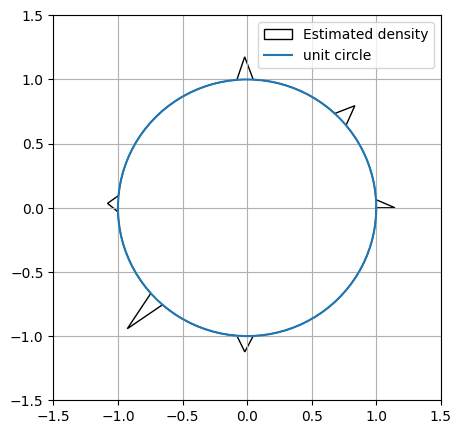

In [360]:
plt.fill(new_points[:, 0], new_points[:, 1], fill=False, label='Estimated density')
plt.plot(points_to_plot[:, 0], points_to_plot[:, 1], label='unit circle', linestyle='-')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.rcParams["figure.figsize"] = (5, 5)
plt.grid(True)
plt.legend()
plt.show()